In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mitsuba
mitsuba.set_variant('gpu_acoustic')
from enoki import *
cuda_set_log_level(0)

2021-06-28 15:20:26 INFO main [optix_api.cpp:56] Dynamic loading of the Optix library ..

In [21]:
def make_shoebox_scene(emitter_pos, sensor_pos, box_dimensions, radius, max_time, time_steps, 
                       spp, bins, rfilter, max_depth, samples_per_pass, scattering,absorption, hide_sensor=True):
    
    from mitsuba.core import ScalarTransform4f

    def transform(scale=None, rotate=None, translate=None):
        if translate is None:
            translate = [0, 0, 0]
        if scale is None:
            scale = [1, 1, 1]
        if rotate is None:
            rotate = ([0, 0, 0], 0)

        a = ScalarTransform4f.scale(scale)
        b = ScalarTransform4f.rotate(*rotate)
        c = ScalarTransform4f.translate(translate)
        return c * b * a

    global_translation = transform(translate=np.array(box_dimensions) / 2)

    scene = {
        "type": "scene",
        "bsdf_neutral": {
            "type": "acousticbsdf",
            "scattering": {
                "type": "spectrum",
                "value": scattering
            },
            "absorption": {
                "type": "spectrum",
                "value": absorption
            }
        },
        "emitter_shape": {
            "id": "emitter",
            "type": "sphere",
            "radius": radius,
            "to_world": transform(translate=emitter_pos),
            "emitter": {
                "type": "area",
                "radiance": {
                    "type": "uniform",
                    "value": 1
                }
            },
            "bsdf": {
                "type": "null"
            }
        },
        "sensor": {
            "type": "microphone",
            "to_world": transform(translate=sensor_pos),
            "sampler": {
                "type": "independent",
                "sample_count": spp
            },
            "myfilm": {
                "type": "tape",
                "time_steps": time_steps,
                "wav_bins": len(bins),
                "rfilter": rfilter
            }  
        },
        "shoebox": {
            "id": "shoebox",
            "type": "obj",
            "filename": "../resources/cuberoom.obj",
            "bsdf": {
                "type": "ref",
                "id": "bsdf_neutral"
            },
            "to_world": global_translation * transform(scale=np.array(box_dimensions) / 2)
        },
        "integrator": {
            "type": "acousticpath",
            "max_depth": int(max_depth),
            "max_time": max_time,
            "wavelength_bins": ','.join(str(x) for x in bins),
            "samples_per_pass": samples_per_pass
        }
    }
    return scene

def get_vals(data, size, copy=True):
    return np.array(data, copy=copy).reshape(size)

def run_simulation(config):
    scene_dict = make_shoebox_scene(**config)
    scene = load_dict(scene_dict)

    size = scene.sensors()[0].film().size()

    sensor = scene.sensors()[0]
    integrator = scene.integrator()

    status = integrator.render(scene, sensor)
    assert status
    
    film = sensor.film()

    data = film.get_histogram().data()
    counts = film.get_histogram().counts()

    vals = get_vals(data, film.size())
    vals_count = get_vals(counts, film.size())
    
    total_samples = config['time_steps'] * config['spp']
 
    edc = vals / total_samples
    #edc = np.nan_to_num(edc)
    #edc = EDC(vals)
    edc_db = db_np(edc)[0]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(15, 5))
    ax1.plot(edc)
    ax1.set_title("Energy")
    ax2.plot(edc_db)
    ax2.set_title("Energy [dB]")
    ax3.plot(vals)
    ax3.set_title("Recorded")
    ax4.plot(vals_count)
    ax4.set_title("Counts")
    
    return edc, edc_db

def EDC(x):
    energy = x * 0.
    # Compute the whole integral
    total = np.trapz(x, axis=0)**2
    for i in range(x.shape[0]):
        energy[i] = (np.trapz(x[i:], axis=0)**2 / total)
    return energy

def db_np(x):
    energy = x * 0.
    # Compute the whole integral
    total = np.trapz(x, axis=0)**2
    for i in range(x.shape[0]):
        energy[i] = (np.trapz(x[i:], axis=0)**2 / total)

    # in dB
    energy_db = 10 * np.log10(energy)
    
    return energy_db, energy

def db_pd(x):
    energy = x * 0.
    # Compute the whole integral
    total = np.trapz(x, axis=0)**2
    for i in range(x.shape[0]):
        energy.iloc[i] = (np.trapz(x[i:], axis=0)**2 / total)

    # in dB
    energy_db = 10 * np.log10(energy)
    
    return energy_db, energy

2021-06-28 15:25:34 DEBUG main [OBJMesh] Loading mesh from "cuberoom.obj" ..

2021-06-28 15:25:34 DEBUG main [OBJMesh] "cuberoom.obj": read 12 faces, 24 vertices (912 B in 0ms)

2021-06-28 15:25:34 INFO main [Scene] Building scene in OptiX ..

2021-06-28 15:25:38 INFO main [TimeDependentIntegrator] Rendering finished. (took 3.627s)

total_samples = 400000
np.sum(vals_count) = 133585936


<ipython-input-21-e00d1ad006ca>:144: RuntimeWarning: divide by zero encountered in log10
  energy_db = 10 * np.log10(energy)


2021-06-28 15:25:38 DEBUG main [OBJMesh] Loading mesh from "cuberoom.obj" ..

2021-06-28 15:25:38 DEBUG main [OBJMesh] "cuberoom.obj": read 12 faces, 24 vertices (912 B in 0ms)

2021-06-28 15:25:38 INFO main [Scene] Building scene in OptiX ..

2021-06-28 15:25:41 INFO main [TimeDependentIntegrator] Rendering finished. (took 3.627s)

total_samples = 400000
np.sum(vals_count) = 137591870


<ipython-input-21-e00d1ad006ca>:144: RuntimeWarning: divide by zero encountered in log10
  energy_db = 10 * np.log10(energy)


2021-06-28 15:25:42 DEBUG main [OBJMesh] Loading mesh from "cuberoom.obj" ..

2021-06-28 15:25:42 DEBUG main [OBJMesh] "cuberoom.obj": read 12 faces, 24 vertices (912 B in 0ms)

2021-06-28 15:25:42 INFO main [Scene] Building scene in OptiX ..

2021-06-28 15:25:45 INFO main [TimeDependentIntegrator] Rendering finished. (took 3.608s)

total_samples = 400000
np.sum(vals_count) = 137685531


<ipython-input-21-e00d1ad006ca>:144: RuntimeWarning: divide by zero encountered in log10
  energy_db = 10 * np.log10(energy)


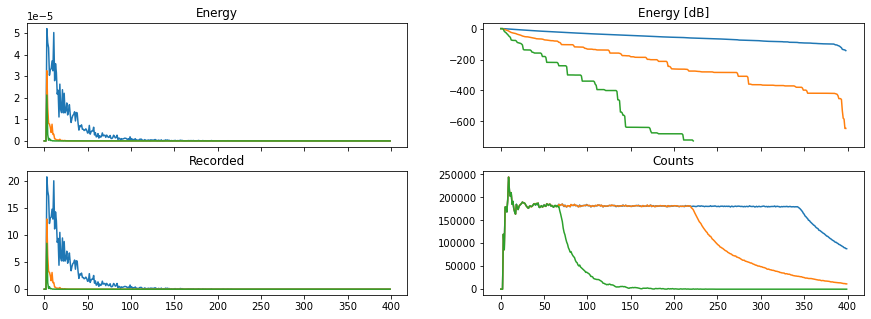

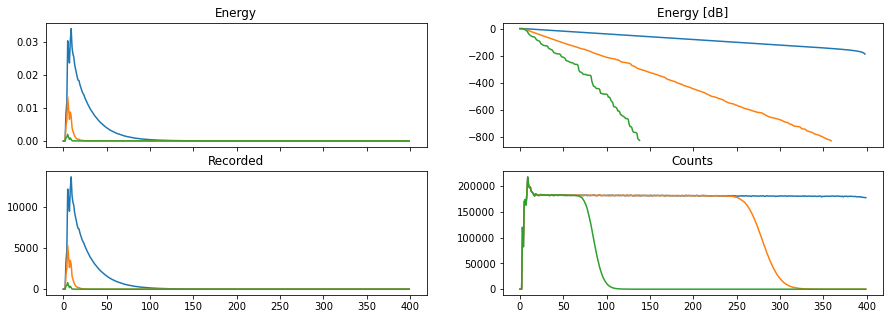

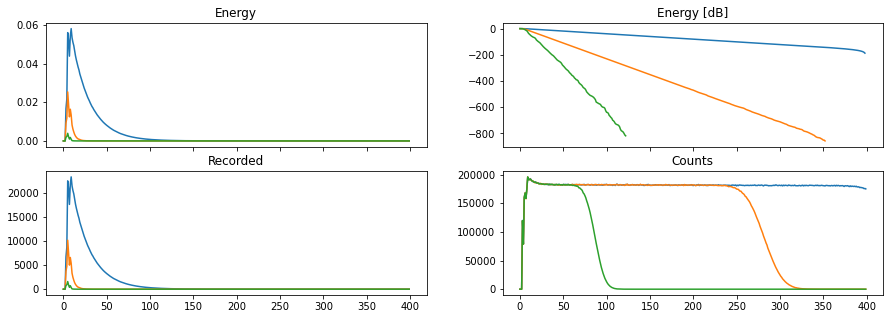

In [22]:
from mitsuba.core.xml import load_string, load_dict

config = {
    "bins": [1, 2, 3],
    "absorption": [(1, 0.1), (2, 0.5), (3, 0.9)],
    "scattering": 0.5,
    "max_time": 4,
    "time_steps": 400,
    "spp": 1000,
    "samples_per_pass": 1000,
    "box_dimensions": [25, 12, 7],
    "emitter_pos": [20, 7, 2],
    "sensor_pos": [9, 6, 1],
    "radius": .1,  
    "max_depth": 200,
    "rfilter": {
        "type": "box",
        "radius": 0.5
    }
}

df = pd.DataFrame()

for s in [0, 0.5, 1.0]:
    config['scattering'] = s
    edc, ed_db = run_simulation(config)
    for i, a in config["absorption"]:
        df.insert(0, f'a{a:.1f}-s{config["scattering"]:.1f}', edc[:,i-1])

In [25]:
df.to_pickle('./data/mitsuba-box-25-12-7.pkl')
raven_hist = pd.read_pickle("raven/data.pkl")

/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/a

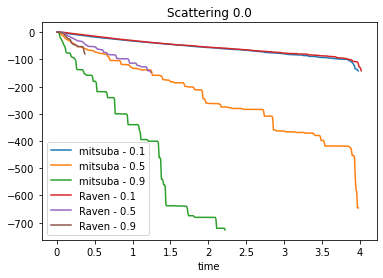

In [26]:
scatter = 0.0

db_pd(df[f'a0.1-s{scatter:.1f}'])[0].plot(label='mitsuba - 0.1')
db_pd(df[f'a0.5-s{scatter:.1f}'])[0].plot(label='mitsuba - 0.5')
db_pd(df[f'a0.9-s{scatter:.1f}'])[0].plot(label='mitsuba - 0.9')

db_pd(raven_hist[f'a0.1-s{scatter:.1f}'])[0].plot(label='Raven - 0.1')
db_pd(raven_hist[f'a0.5-s{scatter:.1f}'])[0].plot(label='Raven - 0.5')
db_pd(raven_hist[f'a0.9-s{scatter:.1f}'])[0].plot(label='Raven - 0.9')
#plt.ylim(-100, 5)
#plt.xlim(0, 0.5)
plt.title(f'Scattering {scatter:.1f}')
plt.legend()

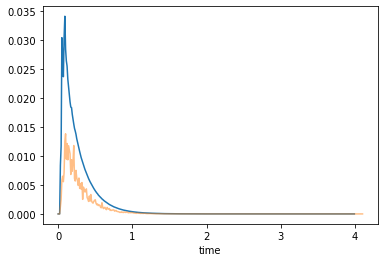

In [27]:
what = 'a0.1-s0.5'

(df[what]).plot()
(raven_hist[what]).plot(alpha=0.5)
plt.show()

<AxesSubplot:xlabel='time'>

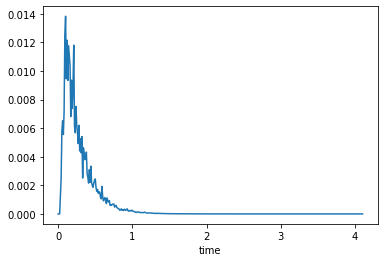

In [28]:
raven_hist['a0.1-s0.5'].plot()